In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install patool
import patoolib                       

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook
%matplotlib inline

     |████████████████████████████████| 77 kB 1.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/my_drive')

Mounted at /content/my_drive


In [3]:
data = pd.read_csv('/content/my_drive/MyDrive/DataSets/Data_processed_new_coords.csv', index_col=0)

In [4]:
data

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,labels,amount_tsh_bool,month_recorded,funder_encoded,installer_encoded,scheme_management_encoded,scheme_name_encoded,public_meeting_encoded,permit_encoded,subvillage_encoded,wpt_name_encoded,management_encoded,payment_encoded,payment_type_encoded,water_quality_encoded,quality_group_encoded,quantity_encoded,basin_encoded,region_encoded,lga_encoded,ward_encoded,extraction_type_encoded,source_encoded,waterpoint_type_encoded
0,1390.0,34.938093,-9.856322,11,5,109.0,1999.0,True,False,3,1548,1706,7,2388,1,0,13116,9784,7,3,0,7,2,1,1,3,51,1429,3,8,1
1,1399.0,34.698766,-2.147466,20,2,280.0,2010.0,True,True,3,522,610,2,2385,1,1,17596,45426,11,1,3,7,2,2,4,9,103,1581,3,5,1
2,686.0,37.460664,-3.821329,21,4,250.0,2009.0,True,False,2,924,2296,7,2261,1,1,10096,17767,7,5,6,7,2,1,5,8,108,1629,3,0,2
3,263.0,38.486161,-11.155298,90,63,58.0,1986.0,True,True,1,1961,2078,7,1130,1,1,9998,45537,7,1,3,7,2,0,7,12,87,1576,14,3,2
4,1328.8,31.130847,-1.825359,18,1,264.0,2005.4,True,True,7,20,133,7,204,1,1,8583,43411,2,1,3,7,2,4,4,4,26,1692,3,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,34.0,38.852669,-6.582841,6,1,20.0,1988.0,False,True,2,293,456,7,168,1,1,21327,30976,7,1,3,7,2,1,8,14,3,2087,7,6,1
14846,1178.4,37.451633,-5.350428,4,7,2960.0,1994.0,False,False,3,584,675,7,2571,1,0,12687,1352,7,3,0,5,5,2,5,20,33,1454,8,7,4
14847,1476.0,34.739804,-4.585587,13,2,200.0,2010.0,False,True,3,1858,1939,7,2638,1,1,4755,1821,7,1,3,7,2,2,0,18,109,2000,3,0,1
14848,998.0,35.432732,-10.584159,10,2,150.0,2009.0,False,True,2,482,442,7,1767,1,1,15803,14467,7,1,3,7,2,2,1,16,111,1072,3,6,1


In [5]:
# Разархивируем архив
patoolib.extract_archive('/content/my_drive/MyDrive/DataSets/Pump_it_Up.rar', outdir='/content' )

patool: Extracting /content/my_drive/MyDrive/DataSets/Pump_it_Up.rar ...
patool: running /usr/bin/unrar x -- /content/my_drive/MyDrive/DataSets/Pump_it_Up.rar
patool:     with cwd='/content'
patool: ... /content/my_drive/MyDrive/DataSets/Pump_it_Up.rar extracted to `/content'.


'/content'

In [6]:
data_labels = pd.read_csv('/content/Pump_it_Up/y_train.csv')

In [8]:
data_labels

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


# Preprocessing

**Посмотрим корреляцию между атрибутами**

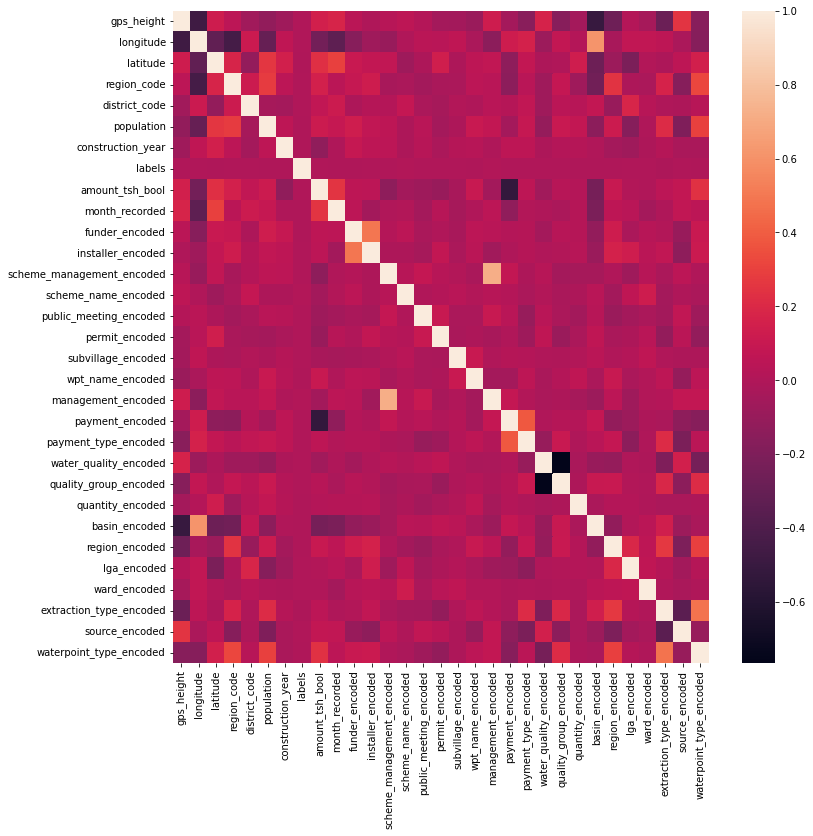

In [9]:
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(method='spearman'))
plt.show()

In [12]:
'''
ЗАМЕТКА:
Из heatmap видно, что management_encoded и scheme_management_encoded
сильно с коррелированы, что может привести к переобучению модели
Поэтому следует удалить один из этих атрибутов
Логичным будет удалить атрибут с более общим признаком, т.е. 'scheme_management_encoded'
'''
print()

In [13]:
data.scheme_management_encoded

0        7
1        2
2        7
3        7
4        7
        ..
14845    7
14846    7
14847    7
14848    7
14849    7
Name: scheme_management_encoded, Length: 74250, dtype: int64

In [14]:
data.drop('scheme_management_encoded', axis=1, inplace=True)

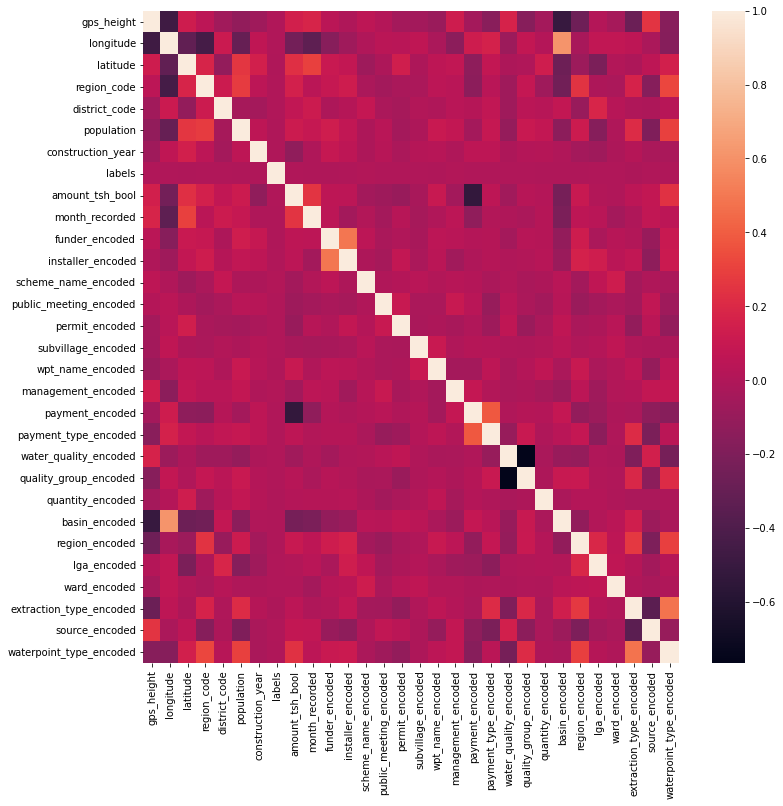

In [15]:
# проверяем успешность удаления
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(method='spearman'))
plt.show()

In [16]:
data_show_copy = data.copy()

In [18]:
# удалим атрибуты с булевыми значениями для копии, чтобы построить гистограммы распределения
data_show_copy.drop('labels', axis=1, inplace=True)
data_show_copy.drop('amount_tsh_bool', axis=1, inplace=True)

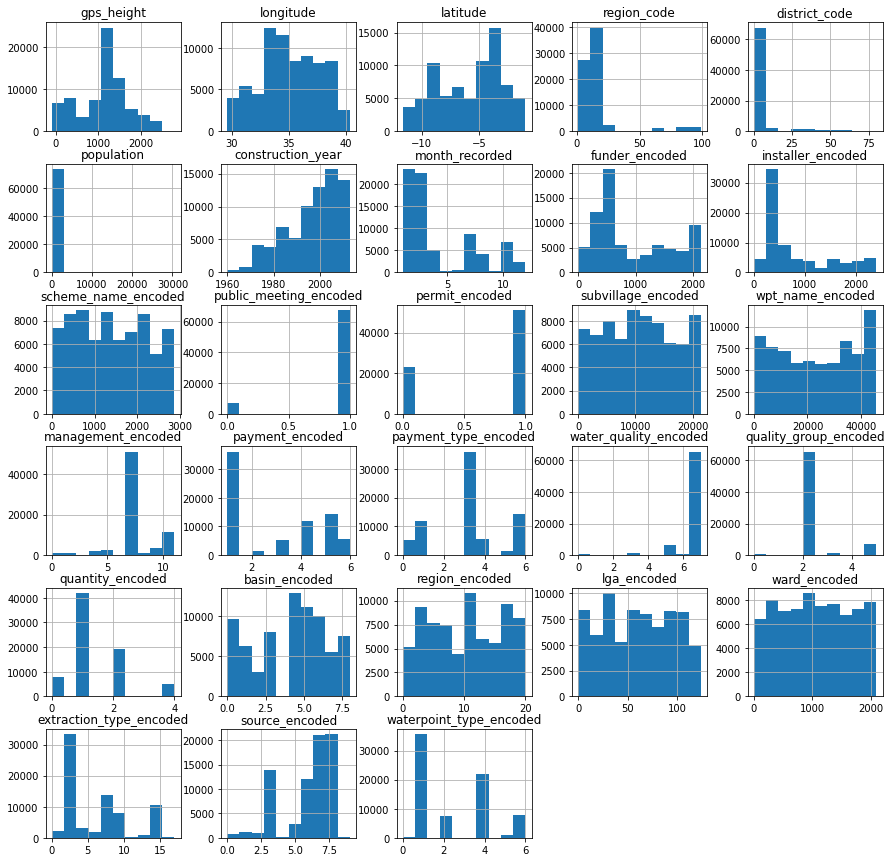

In [19]:
# гистограммы распределения по всем атрибутам
data_show_copy.hist(figsize=(15,15))
plt.show()

In [21]:
for atribute in data.columns:
  space = '                         '
  nou = len(data[atribute].unique())
  print(f'Кол-во уник. знач. для {atribute}{space[len(atribute):]}:', nou)

Кол-во уник. знач. для gps_height               : 3191
Кол-во уник. знач. для longitude                : 72082
Кол-во уник. знач. для latitude                 : 72081
Кол-во уник. знач. для region_code              : 27
Кол-во уник. знач. для district_code            : 20
Кол-во уник. знач. для population               : 1591
Кол-во уник. знач. для construction_year        : 203
Кол-во уник. знач. для labels                   : 2
Кол-во уник. знач. для amount_tsh_bool          : 2
Кол-во уник. знач. для month_recorded           : 12
Кол-во уник. знач. для funder_encoded           : 2140
Кол-во уник. знач. для installer_encoded        : 2410
Кол-во уник. знач. для scheme_name_encoded      : 2868
Кол-во уник. знач. для public_meeting_encoded   : 2
Кол-во уник. знач. для permit_encoded           : 2
Кол-во уник. знач. для subvillage_encoded       : 21425
Кол-во уник. знач. для wpt_name_encoded         : 45683
Кол-во уник. знач. для management_encoded       : 11
Кол-во уник. знач. для paym

In [22]:
'''
ЗАМЕТКА:
Видно, что у некоторых атрибутов очень много уникальных значений, что
плохой показатель для построения любой модели

ЦЕЛЬ:
Избавиться от большого количеста уникальных значений, сохранив содержательность информации

ГИПОТЕЗА:
Вместо самого значения можно использовать частоту его встречаемости по всей выборке, т.е.
если из  1000 данное значение встречается 100 раз, то вместо него пишем 0.1  

ЗАДАЧИ:
- определить пороговое значение количеста уникальных значений атрибута, 
начиная с которого будет применяться замена по частоте
- применить замену по частоте для атрибутов с количеством
уникальных значений выше порога
'''
print()

In [23]:
# оценка частоты встречаемости на примере "wpt_name_encoded"
data.wpt_name_encoded.value_counts(normalize=True)

43411    0.029832
45426    0.013939
1330     0.012040
36358    0.008741
9588     0.005751
           ...   
20899    0.000013
22946    0.000013
16801    0.000013
18848    0.000013
0        0.000013
Name: wpt_name_encoded, Length: 45683, dtype: float64

In [24]:
####################################################
# Частотное заполнение, где пороговое значения - 27.
####################################################

for atribute in data.columns:

  if len(data[atribute].unique()) > 27:
    freq_enc = data[atribute].value_counts(normalize=True)
    data[atribute] = data[atribute].map(freq_enc)


In [25]:
# теперь кол-во уникальных значений сократилось
for atribute in data.columns:
  space = '                         '
  nou = len(data[atribute].unique())
  print(f'Кол-во уник. знач. для {atribute}{space[len(atribute):]}:', nou)

Кол-во уник. знач. для gps_height               : 131
Кол-во уник. знач. для longitude                : 19
Кол-во уник. знач. для latitude                 : 19
Кол-во уник. знач. для region_code              : 27
Кол-во уник. знач. для district_code            : 20
Кол-во уник. знач. для population               : 185
Кол-во уник. знач. для construction_year        : 138
Кол-во уник. знач. для labels                   : 2
Кол-во уник. знач. для amount_tsh_bool          : 2
Кол-во уник. знач. для month_recorded           : 12
Кол-во уник. знач. для funder_encoded           : 177
Кол-во уник. знач. для installer_encoded        : 175
Кол-во уник. знач. для scheme_name_encoded      : 189
Кол-во уник. знач. для public_meeting_encoded   : 2
Кол-во уник. знач. для permit_encoded           : 2
Кол-во уник. знач. для subvillage_encoded       : 112
Кол-во уник. знач. для wpt_name_encoded         : 99
Кол-во уник. знач. для management_encoded       : 11
Кол-во уник. знач. для payment_encoded     

# Modelling

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.dummy import  DummyClassifier
from sklearn.ensemble import RandomForestClassifier

In [27]:
train = data[data.labels==True]
test = data[data.labels==False]
y = data_labels.status_group

In [28]:
y.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [30]:
print(train.shape, y.shape )

(59400, 30) (59400,)


In [33]:
'''
ЗАМЕТКА:
Наблюдается сильная разбалансировка классов:
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677

Поэтому при создании проверочной и тестовой это нужно учитывать
Для сбалансированного деления для метода train_test_split
будем использовать stratify=True
'''
print()

In [34]:
# stratify=True - сбалансированно делит нашу выборку т.е. в x_train и в x_test
# functional, non functional, functional needs repair будут в одинаковых пропорциях

x_train, x_test, y_train, y_test = train_test_split(train, y, 
                                                    test_size=0.3,
                                                    stratify=y.values)

In [35]:
pd_y_train = pd.DataFrame(y_train)
pd_y_test = pd.DataFrame(y_test)

In [36]:
# проверка распределения классов на обучающей выборке
pd_y_train.value_counts(normalize=True)

status_group           
functional                 0.543074
non functional             0.384247
functional needs repair    0.072679
dtype: float64

In [37]:
# проверка распределения классов на тестовой выборке
pd_y_test.value_counts(normalize=True)

status_group           
functional                 0.543098
non functional             0.384231
functional needs repair    0.072671
dtype: float64

## DummyClassifier

In [38]:
dummy_clf = DummyClassifier()
dummy_clf.fit(x_train, y_train)

DummyClassifier()

In [39]:
baseline_train = dummy_clf.predict(x_train)
baseline_test = dummy_clf.predict(x_test)

In [40]:
print(classification_report(y_test, baseline_test))

                         precision    recall  f1-score   support

             functional       0.54      1.00      0.70      9678
functional needs repair       0.00      0.00      0.00      1295
         non functional       0.00      0.00      0.00      6847

               accuracy                           0.54     17820
              macro avg       0.18      0.33      0.23     17820
           weighted avg       0.29      0.54      0.38     17820



In [50]:
'''
Точность на DummyClassifier: 0.29  
'''
print()

##LogisticRegressionCV

In [45]:
log_reg = LogisticRegressionCV()

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [46]:
log_reg.fit(x_train_scaled, y_train)

LogisticRegressionCV()

In [47]:
log_reg_pred_train = log_reg.predict(x_train_scaled)
log_reg_pred_test = log_reg.predict(x_test_scaled)

In [48]:
log_reg_pred_test

array(['functional', 'functional', 'functional', ..., 'non functional',
       'non functional', 'functional'], dtype=object)

In [49]:
print(classification_report(y_test, log_reg_pred_test))

                         precision    recall  f1-score   support

             functional       0.64      0.83      0.72      9678
functional needs repair       0.00      0.00      0.00      1295
         non functional       0.64      0.49      0.56      6847

               accuracy                           0.64     17820
              macro avg       0.43      0.44      0.43     17820
           weighted avg       0.59      0.64      0.61     17820



In [51]:
'''
Точность на LogisticRegressionCV: 0.59  
'''
print()

## RandomForestClassifier

In [52]:
max_depth_list = [2,4,8,16,32,None]

In [53]:
def chose_max_depth(max_depth_list):

  for i in tqdm_notebook(max_depth_list):
    rf_clf = RandomForestClassifier(n_estimators=200, max_depth=i)
    rf_clf.fit(x_train, y_train)
    rf_pred_train = rf_clf.predict(x_train)
    rf_reg_pred_test = rf_clf.predict(x_test)
    print(f'------------------------{i}-------------------------------')
    print(classification_report(y_test, rf_reg_pred_test))

In [54]:
chose_max_depth(max_depth_list)

  0%|          | 0/6 [00:00<?, ?it/s]

------------------------2-------------------------------
                         precision    recall  f1-score   support

             functional       0.64      0.98      0.78      9678
functional needs repair       0.00      0.00      0.00      1295
         non functional       0.92      0.41      0.57      6847

               accuracy                           0.69     17820
              macro avg       0.52      0.46      0.45     17820
           weighted avg       0.70      0.69      0.64     17820

------------------------4-------------------------------
                         precision    recall  f1-score   support

             functional       0.66      0.97      0.79      9678
functional needs repair       0.00      0.00      0.00      1295
         non functional       0.88      0.48      0.62      6847

               accuracy                           0.71     17820
              macro avg       0.51      0.48      0.47     17820
           weighted avg       0.70  

In [61]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20)
rf_clf.fit(x_train, y_train)
rf_pred_train = rf_clf.predict(x_train)
rf_reg_pred_test = rf_clf.predict(x_test)
print(classification_report(y_test, rf_reg_pred_test))

                         precision    recall  f1-score   support

             functional       0.79      0.91      0.84      9678
functional needs repair       0.60      0.27      0.37      1295
         non functional       0.85      0.76      0.80      6847

               accuracy                           0.80     17820
              macro avg       0.75      0.65      0.67     17820
           weighted avg       0.80      0.80      0.79     17820



In [62]:
'''
Точность на RandomForestClassifier: 0.8 
'''
print()

# Submission

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20)
rf_clf.fit(train, y)

RandomForestClassifier(max_depth=20)

In [ ]:
submit_pred = rf_clf.predict(test)

In [ ]:
submit_pred

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [ ]:
submit_form = pd.read_csv('/content/Pump_it_Up/SubmissionFormat.csv')

In [ ]:
submit_form

,id,status_group
0,50785,predicted label
1,51630,predicted label
2,17168,predicted label
3,45559,predicted label
4,49871,predicted label
...,...,...
14845,39307,predicted label
14846,18990,predicted label
14847,28749,predicted label
14848,33492,predicted label


In [ ]:
submit_form['status_group'] = submit_pred

In [ ]:
submit_form

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [ ]:
submit_form.to_csv('/content/my_drive/MyDrive/DataSets/submit_3_new_coords.csv', index=False)

# Accuracy on DrivenData


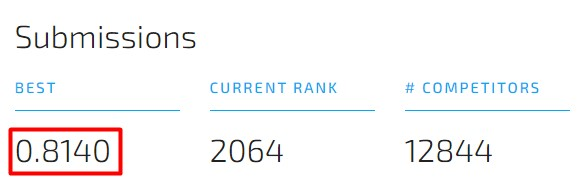